In [22]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

In [23]:
output_path = '/usr2/key/Projects/QuantumAnnealing/TopoFlowManuscript/fig/parameter_study/diffuser/regularizationDissipation'

In [24]:
textwidth_in_inches = 500.484/72.27

In [25]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 8
n_elem_for_height = 9

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

In [26]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [27]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # Parallel outflow, i.e., no vertical velocity.
            BC.append([node, 1, 0.0])
boundary_values_v = np.array(BC)

In [28]:
viscosity = 1.0
density = 1.0

In [29]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=8.e-2)
fem.set_boudary_values_v(boundary_values_v)

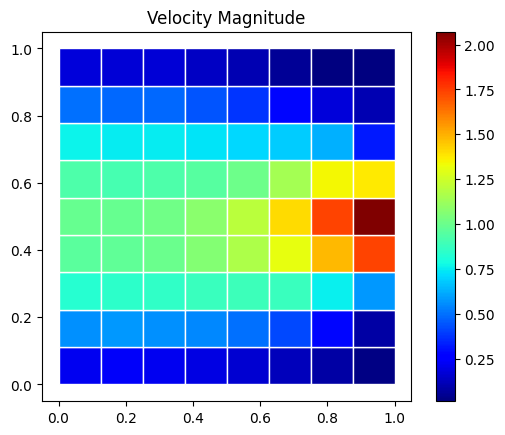

In [30]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

In [31]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
level_set_scaled_initial = np.ones(mesh_v.n_elem) # Initial scaled level-set function, i.e., design variable, for each element.

In [32]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 500
client.parameters.outputs.duplicate = True

if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')
    
annealing_solver = AnnealingSolver(client)

In [33]:
# Topology Optimization Problem
n_qubits_per_variable = 5
hyperparameters = {
    'energy_dissipation': 100.,
    'regularization': 1.,
    'volume_constraint': 20.,
    'char_func': 4.,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

In [34]:
# Annealing-Based Optimizer (Two-Step Optimization)
annealing_optimizer = Annealing(fem)
max_opt_steps = 10

Iteration: 0, Objective Function: 0.0685904064950345, Volume Fraction: 0.6111111111111112, Inconsistencies: 1


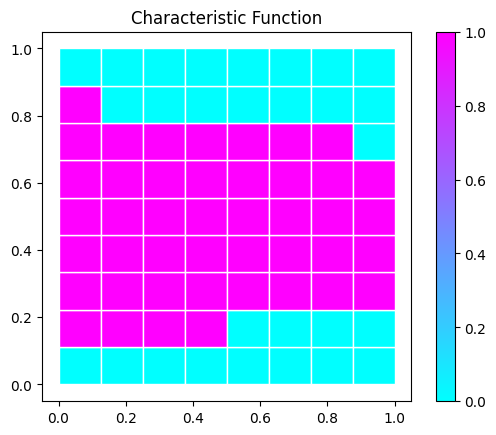

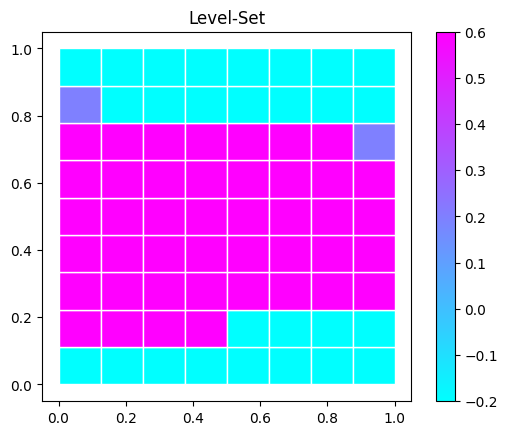

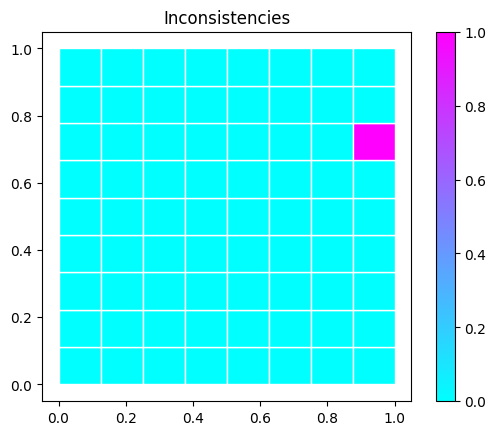

Abs. change in
	char. func.:28.0
Rel. change in
	char. func.:0.3888888888888889
	Obj. func.: 0.9807208980927596
Iteration: 1, Objective Function: 0.07933568962765983, Volume Fraction: 0.5694444444444444, Inconsistencies: 0


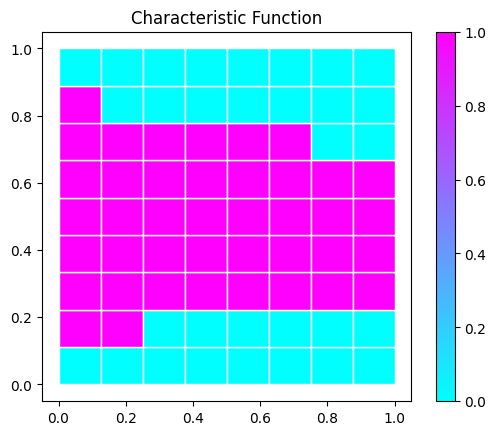

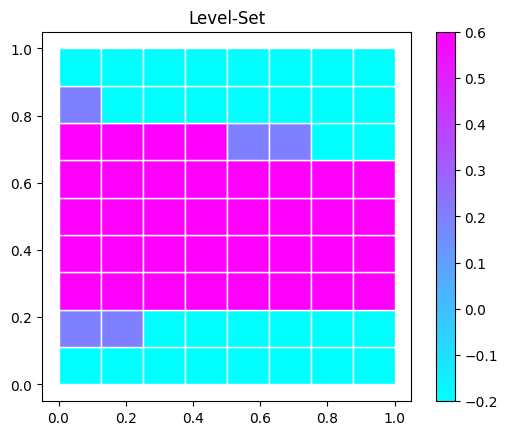

Abs. change in
	char. func.:3.0
Rel. change in
	char. func.:0.06818181818181818
	Obj. func.: 0.15665868860834364
Iteration: 2, Objective Function: 0.08371211656453545, Volume Fraction: 0.5555555555555556, Inconsistencies: 0


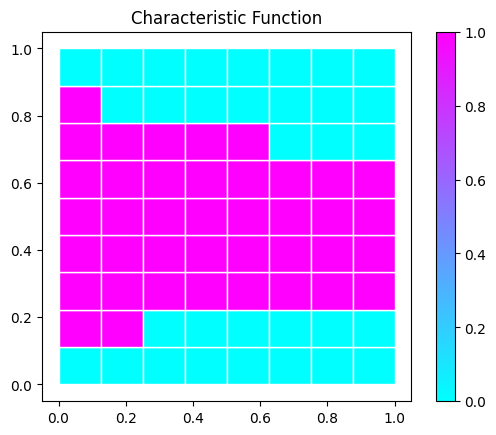

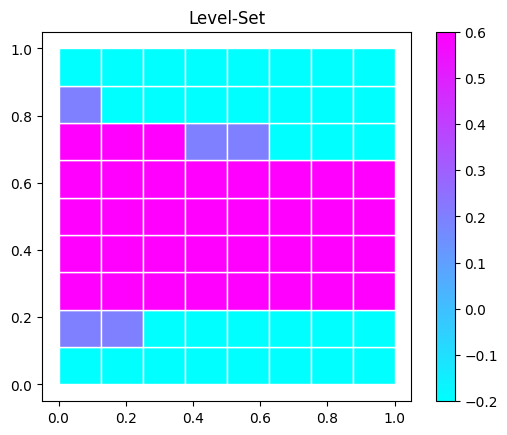

Abs. change in
	char. func.:1.0
Rel. change in
	char. func.:0.024390243902439025
	Obj. func.: 0.05516340700402522
Iteration: 3, Objective Function: 0.08371211656453545, Volume Fraction: 0.5555555555555556, Inconsistencies: 0


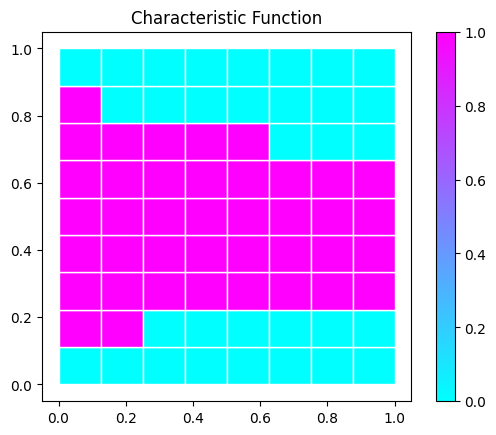

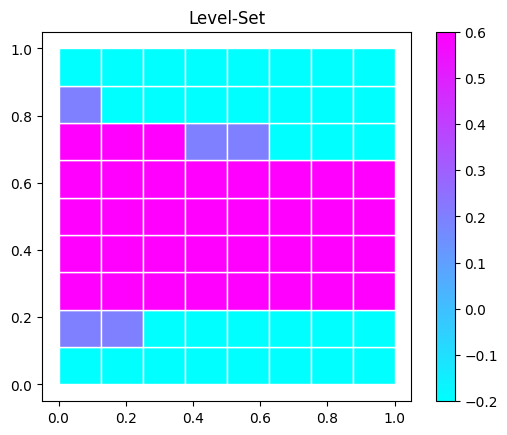

Abs. change in
	char. func.:0.0
Rel. change in
	char. func.:0.0
	Obj. func.: 0.0


In [35]:
annealing_optimizer.optimize(annealing_solver, 
                                    topo_opt_problem,
                                    level_set_scaled_initial, 
                                    max_opt_steps, tol=1e-2, plot_steps=True)